In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [ ]:
sns.set_theme()

# 1. Dataset preparation

In [ ]:
RANDOM_SEED = 0
ds = "https://proai-datasets.s3.eu-west-3.amazonaws.com/housing.csv"

In [ ]:
df = pd.read_csv(ds)
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,2
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,2
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0


In [ ]:
df.shape

(545, 13)

We don't see any missing data.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


In [ ]:
df.count()

,0
price,545
area,545
bedrooms,545
bathrooms,545
stories,545
mainroad,545
guestroom,545
basement,545
hotwaterheating,545
airconditioning,545


In [ ]:
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


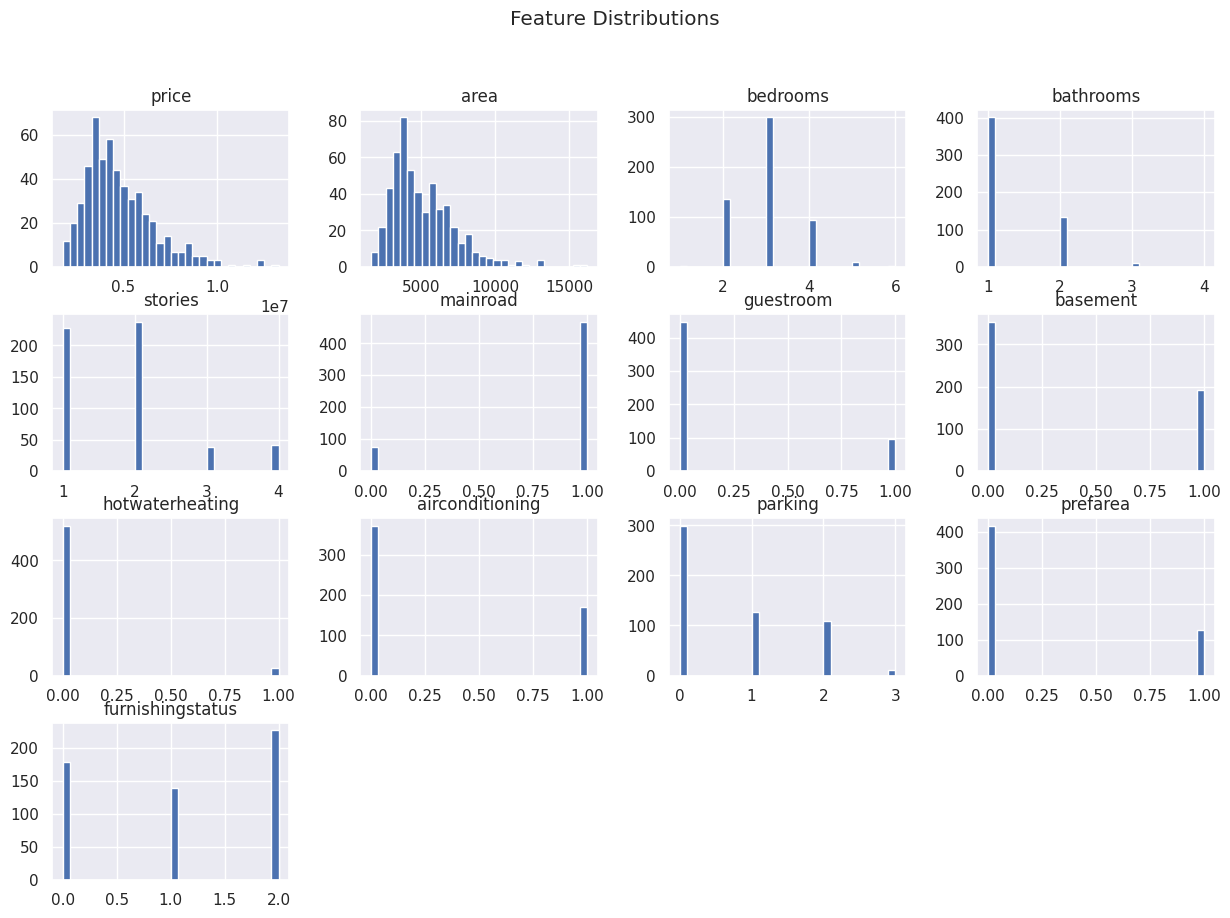

In [ ]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

We prepare one hot encoding for the categorical variables

In [ ]:
categorical_columns = ["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea", "furnishingstatus"]

df_ohe =  pd.get_dummies(
    df, columns=categorical_columns,
    dtype=int,
    drop_first=False
    )
df_ohe.head(10)

,price,area,bedrooms,bathrooms,stories,parking,mainroad_0,mainroad_1,guestroom_0,guestroom_1,...,basement_1,hotwaterheating_0,hotwaterheating_1,airconditioning_0,airconditioning_1,prefarea_0,prefarea_1,furnishingstatus_0,furnishingstatus_1,furnishingstatus_2
0,13300000,7420,4,2,3,2,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
1,12250000,8960,4,4,4,3,0,1,1,0,...,0,1,0,0,1,1,0,0,1,0
2,12250000,9960,3,2,2,2,0,1,1,0,...,1,1,0,1,0,0,1,0,0,1
3,12215000,7500,4,2,2,3,0,1,1,0,...,1,1,0,0,1,0,1,0,1,0
4,11410000,7420,4,1,2,2,0,1,0,1,...,1,1,0,0,1,1,0,0,1,0
5,10850000,7500,3,3,1,2,0,1,1,0,...,1,1,0,0,1,0,1,0,0,1
6,10150000,8580,4,3,4,2,0,1,1,0,...,0,1,0,0,1,0,1,0,0,1
7,10150000,16200,5,3,2,0,0,1,1,0,...,0,1,0,1,0,1,0,1,0,0
8,9870000,8100,4,1,2,2,0,1,0,1,...,1,1,0,0,1,0,1,0,1,0
9,9800000,5750,3,2,4,1,0,1,0,1,...,0,1,0,0,1,0,1,1,0,0


We change the 0s and 1s for something more meaningful:

In [ ]:
def rename_cat_cols(columns, cat_columns, categories):
  new_columns = {}

  for col in columns:
    if "_" in col:
      colname, cat = col.split("_")

      if colname in cat_columns:
        new_columns[col] = colname+"_" + categories[int(cat)]

  return new_columns

In [ ]:
cats = {0: "no", 1: "yes"}
columns = df_ohe.columns

new_columns = rename_cat_cols(columns, categorical_columns[:-1], cats)

df_ohe.rename(columns=new_columns, inplace=True)

In [ ]:
furnishing_cats = {0: "none", 1: "semi", 2: "full"}

new_columns = rename_cat_cols(columns, [categorical_columns[-1]], furnishing_cats)
df_ohe.rename(columns=new_columns, inplace=True)

In [ ]:
df_ohe.head()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,...,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_none,furnishingstatus_semi,furnishingstatus_full
0,13300000,7420,4,2,3,2,0,1,1,0,...,0,1,0,0,1,0,1,0,1,0
1,12250000,8960,4,4,4,3,0,1,1,0,...,0,1,0,0,1,1,0,0,1,0
2,12250000,9960,3,2,2,2,0,1,1,0,...,1,1,0,1,0,0,1,0,0,1
3,12215000,7500,4,2,2,3,0,1,1,0,...,1,1,0,0,1,0,1,0,1,0
4,11410000,7420,4,1,2,2,0,1,0,1,...,1,1,0,0,1,1,0,0,1,0


# 2. Regression models implementations

## 2.a. Model #1

First we'll try to identify highly correlated variables to price:
* area 0.54
* bathrooms 0.52
* air conditioning 0.45
* stories 0.42
* parking 0.38
* bedrooms 0.37

<Axes: >

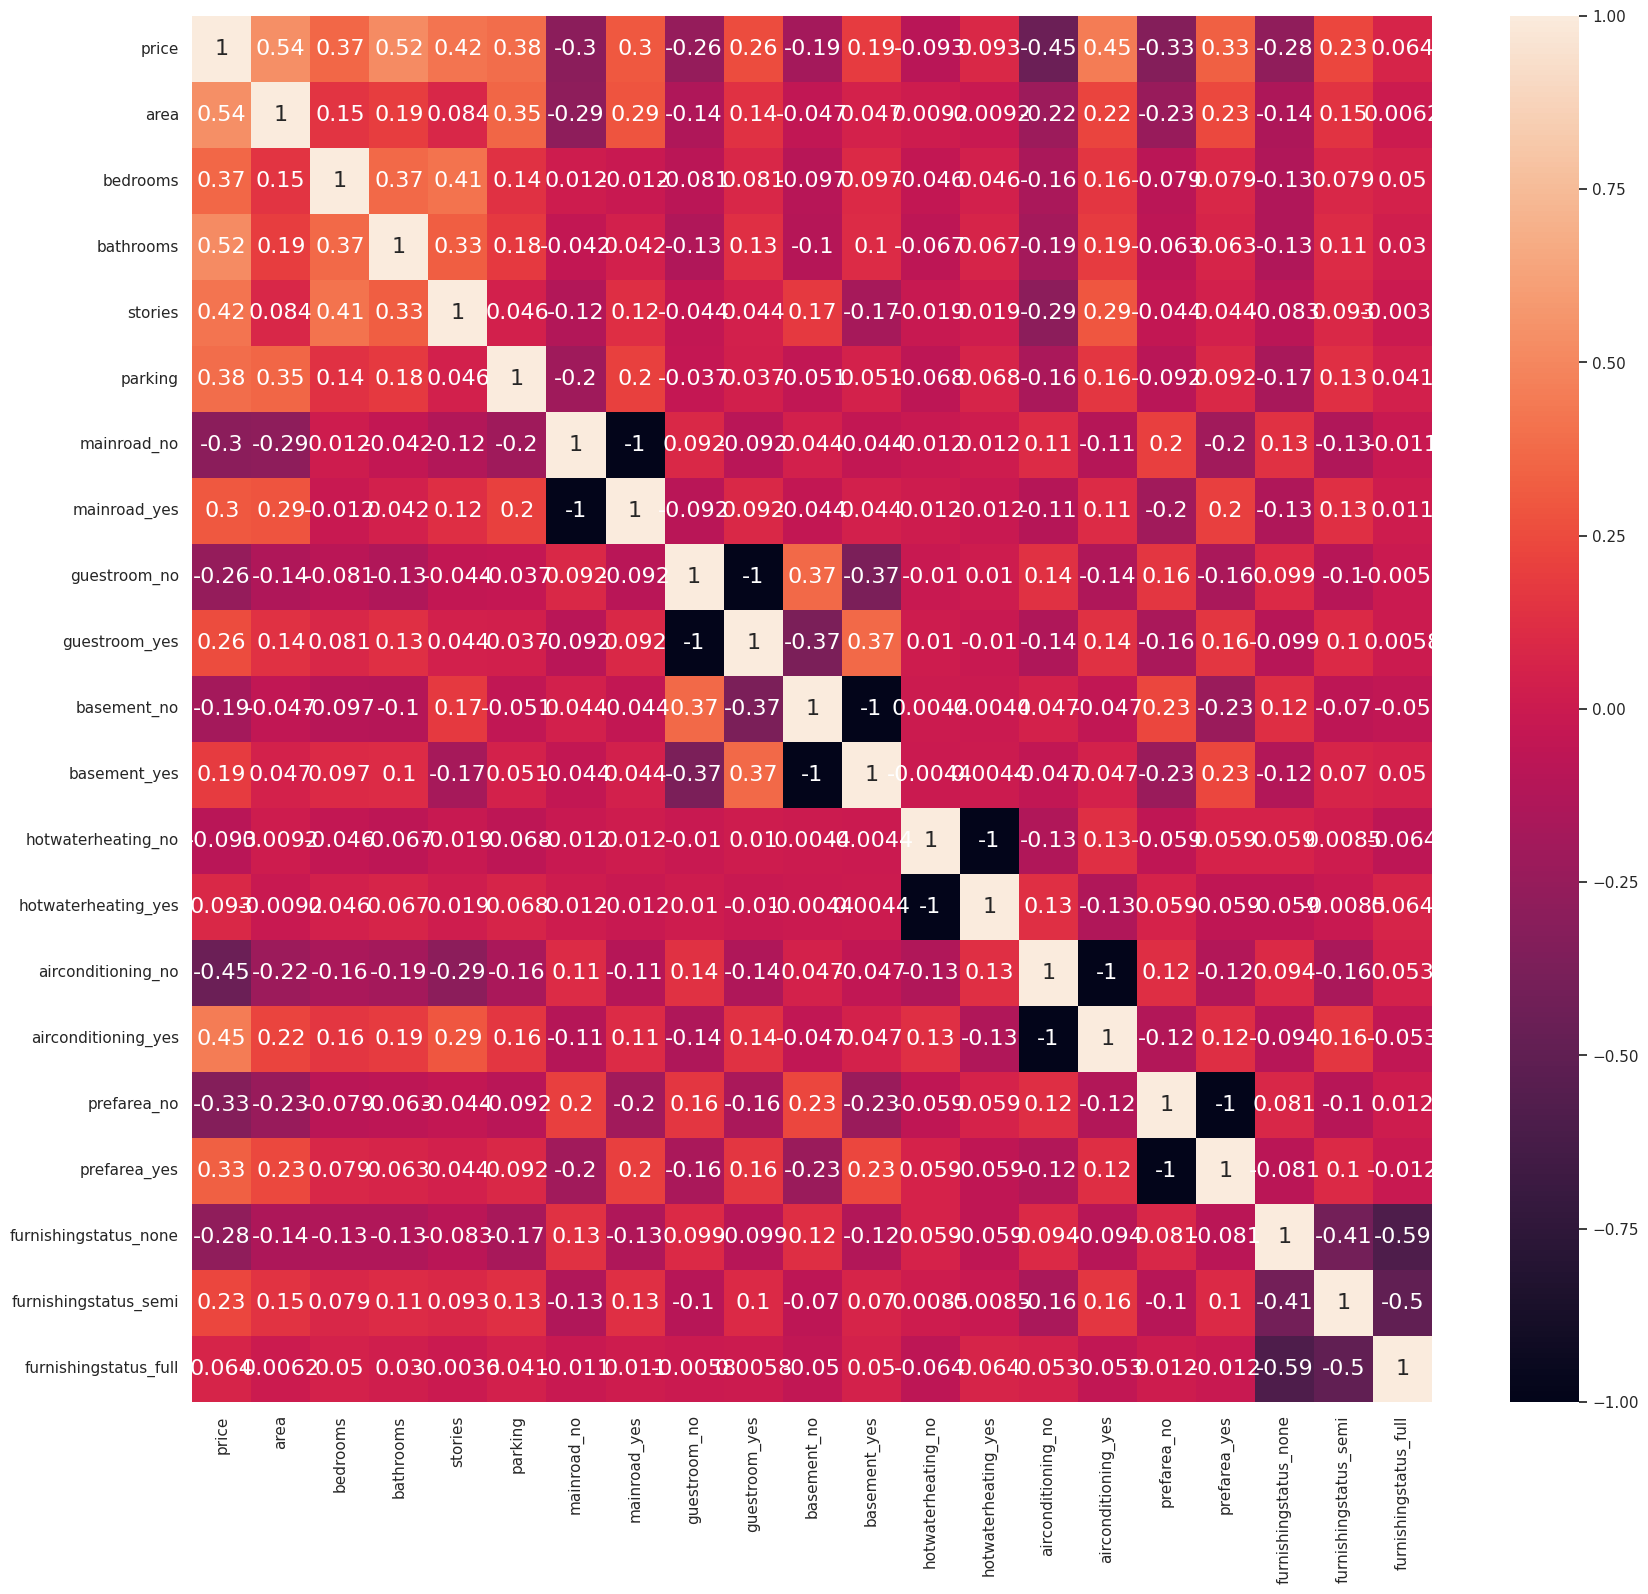

In [ ]:
plt.figure(figsize=(20,18))
sns.heatmap(df_ohe.corr(), annot=True, annot_kws={"size": 16})

In this model we'll keep only the most relevant features and see how it goes:

In [ ]:
X = df_ohe[["area","bathrooms","airconditioning_yes","airconditioning_no","stories","parking","bedrooms"]]
y = df_ohe["price"]

We create a function in order to do a grid search using different regression models:

In [ ]:
def grid_search_cv(X, y, model_name, poly_degrees=[1], alpha_values=[1.], l1_ratio=0.5):
  """
  Performs a grid search cross-validation to find the best parameters for a given model.
  X: features dataset including columns.
  y: target dataset including columns.
  model_name: lr (linear regression), ridge, lasso, elasticnet.
  poly_degrees: list of degrees.
  alpha_values: list of alpha values. Not used by lr.
  l1_ratio: float between 0 and 1, only used by elasticnet.
  """

  results = []
  best_model = None
  best_params = None
  best_result = {
      'r2': 0,
      'rmse': float('inf')
  }

  features = X.columns
  X = X.values
  y = y.values

  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  # we iterate cross-validation
  for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for degree in poly_degrees:
        # check degree to apply polynomial
        if degree > 1:
          poly = PolynomialFeatures(degree=degree)
          X_train_poly = poly.fit_transform(X_train)
          X_test_poly = poly.transform(X_test)
          feature_names = poly.get_feature_names_out(input_features=features)
        else:
          X_train_poly, X_test_poly = X_train, X_test
          feature_names = features

        # apply feature scaling by using standardization:
        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train_poly)
        X_test_ss = ss.transform(X_test_poly)

        # calculate for every alpha
        for alpha in alpha_values:
          if model_name == "lr":
            model = LinearRegression()
          if model_name == "ridge":
            model = Ridge(alpha=alpha)
          elif model_name == "lasso":
            model = Lasso(alpha=alpha)
          elif model_name == "elasticnet":
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

          model.fit(X_train_ss, y_train)

          # Count the number of nonzero coefficients
          nonzero_coef_count = np.sum(model.coef_ != 0)

          r2_train = r2_score(y_train, model.predict(X_train_ss))
          r2_test = r2_score(y_test, model.predict(X_test_ss))

          mse_train = mean_squared_error(y_train, model.predict(X_train_ss))
          mse_test = mean_squared_error(y_test, model.predict(X_test_ss))

          rmse_train = np.sqrt(mse_train)
          rmse_test = np.sqrt(mse_test)

          # store the best params and metrics so far
          if r2_test > best_result['r2'] or (r2_test == best_result['r2'] and rmse_test < best_result['rmse']):
            best_model = model
            best_result = {'r2': r2_test, 'rmse': rmse_test}
            best_params = pd.Series({
                'model_name': model_name,
                'degree': degree,
                'alpha': alpha if model_name != 'lr' else 'n/a',
                'l1_ratio': l1_ratio if model_name == "elasticnet" else 'n/a',
                'r2_train': r2_train,
                'mse_train': mse_train,
                'rmse_train': rmse_train,
                'r2_test': r2_test,
                'rmse_test': rmse_test,
                'nonzero_coef': nonzero_coef_count,
                'feature_names': feature_names,
                'coef': model.coef_,
            })

          # store results from every model tested
          results.append({
              'model_name': model_name,
              'degree': degree,
              'alpha': alpha if model_name != 'lr' else 'n/a',
              'l1_ratio': l1_ratio if model_name == "elasticnet" else 'n/a',
              'r2_train': round(r2_train, 4),
              'mse_train': round(mse_train),
              'rmse_train': round(rmse_train),
              'r2_test': round(r2_test, 4),
              'mse_test': round(mse_test),
              'rmse_test': round(rmse_test),
              'nonzero_coef': nonzero_coef_count,
          })

  results_df = pd.DataFrame(results)
  ordered = results_df.sort_values(by=['r2_test', 'rmse_test'], ascending=[False, True])

  return ordered, best_params, best_model

### Linear regression

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="lr")

In [ ]:
results

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
0,lr,1,n/a,n/a,0.5958,1473005224048,1213674,0.6560,991340963294,995661,7
1,lr,1,n/a,n/a,0.5964,1279194043946,1131015,0.6242,1782942902620,1335269,7
2,lr,1,n/a,n/a,0.6084,1401338188567,1183781,0.5812,1292256614614,1136775,7
4,lr,1,n/a,n/a,0.6144,1372446384230,1171515,0.5674,1394313266861,1180810,7
3,lr,1,n/a,n/a,0.6249,1314154412188,1146366,0.5216,1643920432610,1282155,7


In [ ]:
best_params

,0
model_name,lr
degree,1
alpha,n/a
l1_ratio,n/a
r2_train,0.595793
mse_train,1473005224047.556152
rmse_train,1213674.26604
r2_test,0.655966
rmse_test,995661.068484
nonzero_coef,7


We create a function to plot the predictions:

In [ ]:
def plot_prediction(X, y, model, best_params):
  """
  Plot predictions and regression line.
  X: features dataset including columns.
  y: target dataset including columns.
  model: the one generated.
  best_params: output from 'grid_search_cv'.
  """
  X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=.3, random_state=RANDOM_SEED)
  degree = best_params["degree"]

  if degree > 1:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
  else:
    X_train_poly, X_test_poly = X_train, X_test

  ss = StandardScaler()
  X_train_ss = ss.fit_transform(X_train_poly)
  X_test_ss = ss.transform(X_test_poly)

  y_pred = model.predict(X_test_ss)

  plt.figure(figsize=(12, 10))

  sns.scatterplot(x=y_test, y=y_pred)
  # draw regression line / curve
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

  plt.suptitle("Actual vs Predicted Housing Prices")
  plt.figtext(0.5, 0.90, f"model={best_params['model_name']}  alpha={best_params['alpha']}  degree={best_params['degree']}  l1_ratio={best_params['l1_ratio']}  r2_test={best_params['r2_test']:.4f}  rmse_test={best_params['rmse_test']:.0f}  nonzero_coef={best_params['nonzero_coef']}", ha="center", fontsize=10)
  plt.xlabel("Actual Price (M)")
  plt.ylabel("Predicted Price (M)")
  plt.ticklabel_format(style='plain', axis='both')

  formatter = FuncFormatter(lambda x, pos: f'{x*1e-6:,.0f}M')

  plt.gca().xaxis.set_major_formatter(formatter)
  plt.gca().yaxis.set_major_formatter(formatter)

  plt.show()

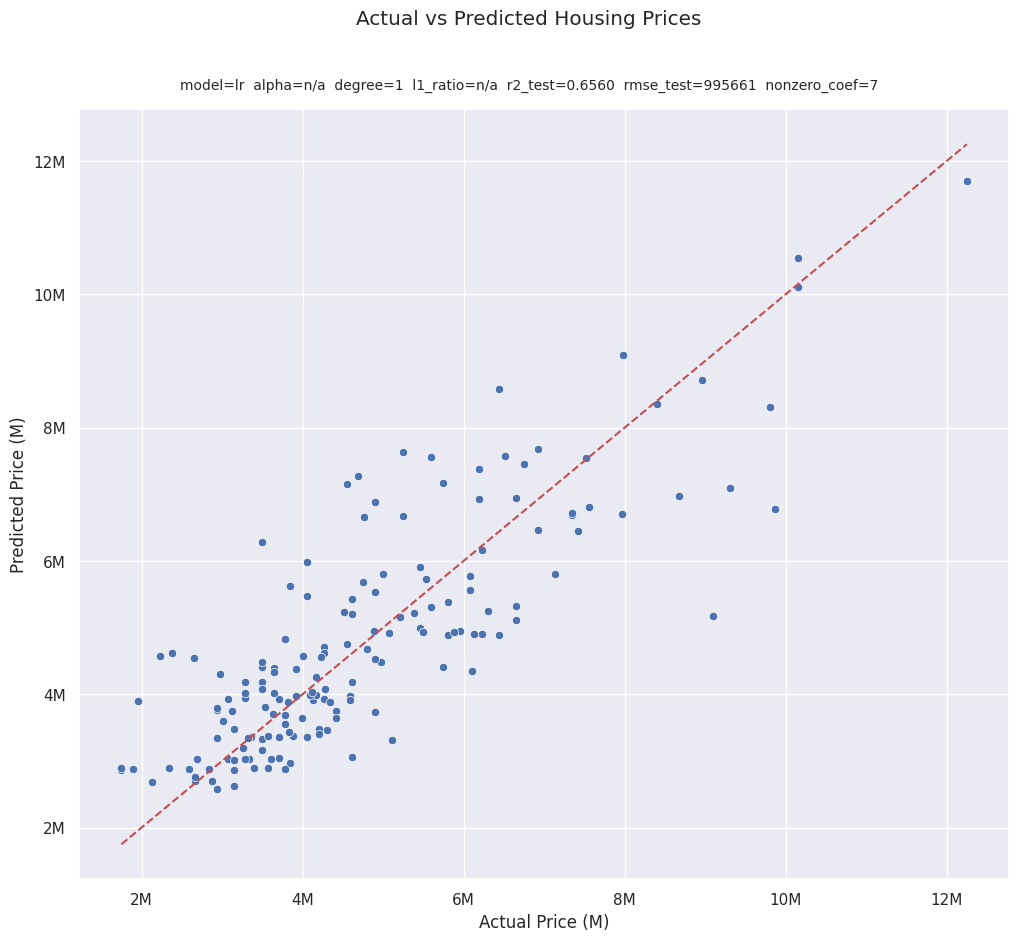

In [ ]:
plot_prediction(X, y, best_model, best_params)

### Ridge

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="ridge", alpha_values=[.1, 1, 5, 10, 20, 50, 100, 200], poly_degrees=[1,2,3])

In [ ]:
results

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
6,ridge,1,100.0,n/a,0.5886,1499357679566,1224483,0.6687,954587231616,977030,7
5,ridge,1,50.0,n/a,0.5937,1480812311156,1216886,0.6657,963297000450,981477,7
7,ridge,1,200.0,n/a,0.5739,1552837303615,1246129,0.6637,969159101322,984459,7
4,ridge,1,20.0,n/a,0.5954,1474408857156,1214252,0.6609,977116789556,988492,7
3,ridge,1,10.0,n/a,0.5957,1473371180547,1213825,0.6586,983650794261,991792,7
...,...,...,...,...,...,...,...,...,...,...,...
66,ridge,3,5.0,n/a,0.6859,1123961184852,1060170,0.4671,1644218464974,1282271,111
65,ridge,3,1.0,n/a,0.7019,1066913462106,1032915,0.4170,1798993382869,1341266,111
41,ridge,3,1.0,n/a,0.6824,1006491407453,1003240,0.3844,2920431146371,1708927,111
64,ridge,3,0.1,n/a,0.7180,1009285724393,1004632,0.3491,2008621928179,1417259,111


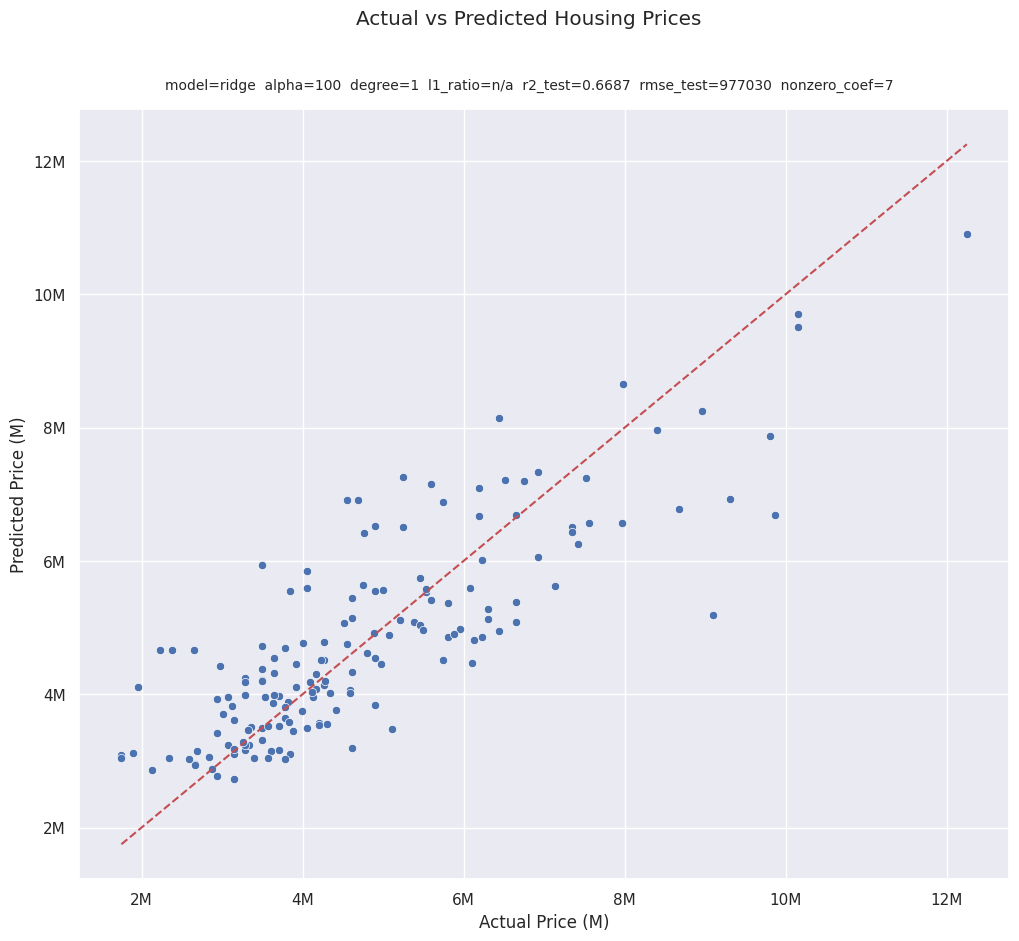

In [ ]:
plot_prediction(X, y, best_model, best_params)

### Lasso

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="lasso", alpha_values=[.1, 1, 5, 10], poly_degrees=[1,2,3])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+14, tolerance: 1.589e

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
3,lasso,1,10.0,n/a,0.5958,1473005224273,1213674,0.6560,991337966335,995660,7
0,lasso,1,0.1,n/a,0.5958,1473005224048,1213674,0.6560,991340905401,995661,7
1,lasso,1,1.0,n/a,0.5958,1473005224050,1213674,0.6560,991340367567,995661,7
2,lasso,1,5.0,n/a,0.5958,1473005224166,1213674,0.6560,991340960043,995661,7
12,lasso,1,0.1,n/a,0.5964,1279194043946,1131015,0.6242,1782943004146,1335269,6


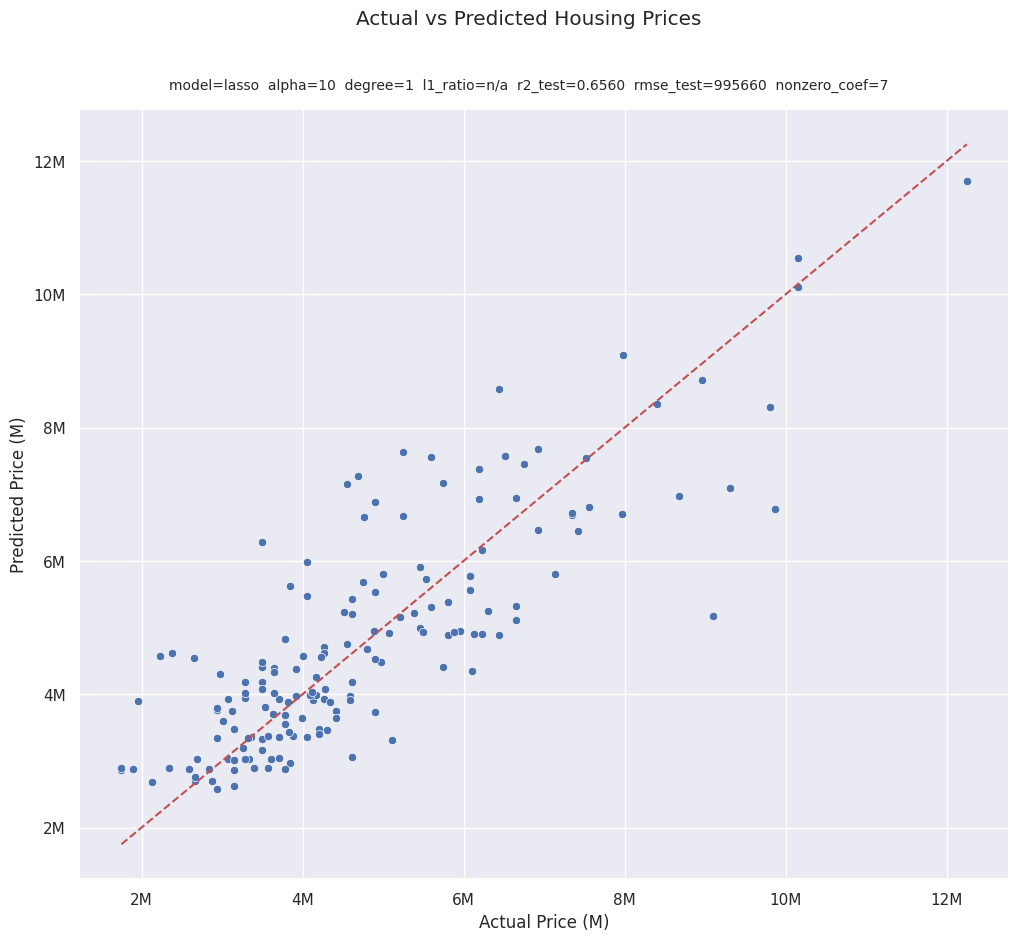

In [ ]:
plot_prediction(X, y, best_model, best_params)

### ElasticNet

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="elasticnet", alpha_values=[.1, 1, 5, 10, 20, 50, 100, 200], poly_degrees=[1,2,3])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.878e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.818e+13, tolerance: 1.589e

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
10,elasticnet,2,5.0,0.5,0.5728,1556823168179,1247727,0.6665,961009514451,980311,34
1,elasticnet,1,1.0,0.5,0.5709,1563787852910,1250515,0.6618,974614923612,987226,7
0,elasticnet,1,0.1,0.5,0.5953,1474660625781,1214356,0.6613,976053579954,987954,7
9,elasticnet,2,1.0,0.5,0.6035,1445017114523,1202089,0.6518,1003236000896,1001617,34
11,elasticnet,2,10.0,0.5,0.5318,1706043286167,1306156,0.6433,1027846425943,1013828,34


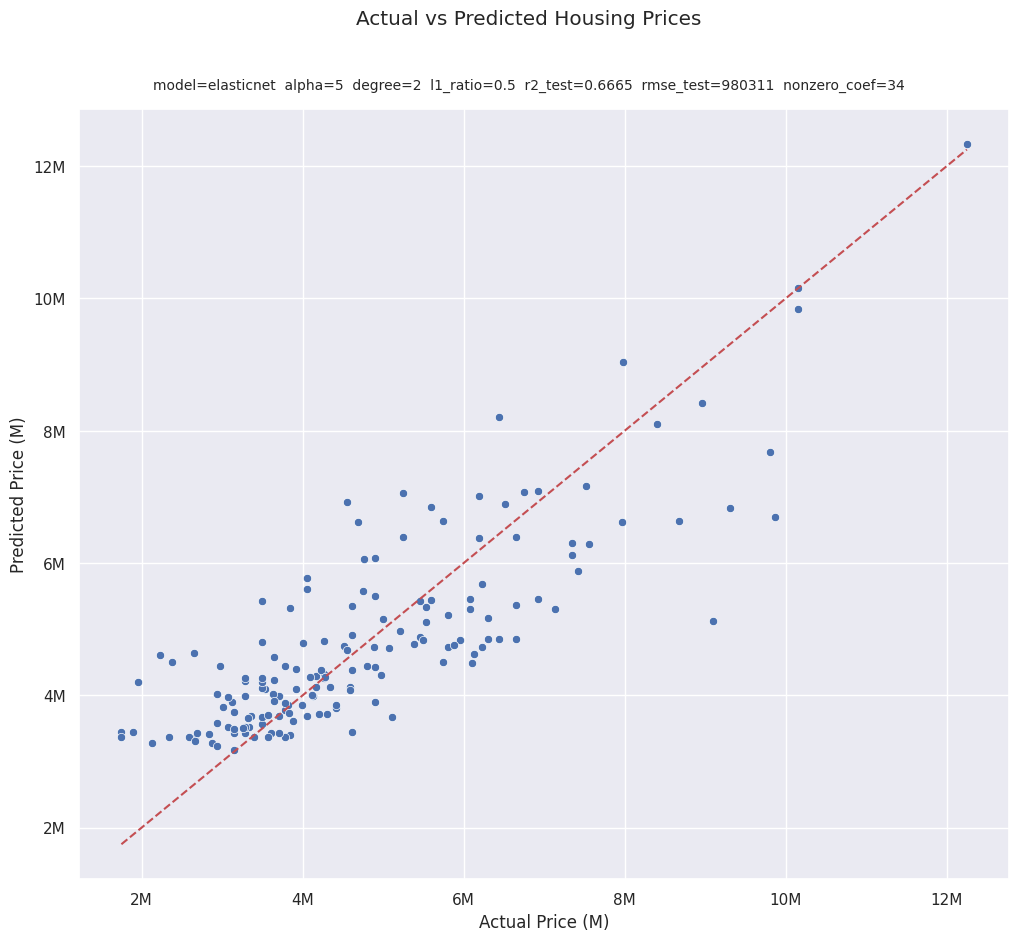

In [ ]:
plot_prediction(X, y, best_model, best_params)

It seems that the Ridge model is better, let's do some fine-tuning:

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="ridge", alpha_values=[90, 100, 110, 120], poly_degrees=[1,2,3])

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
2,ridge,1,110,n/a,0.5873,1503918052699,1226343,0.6688,954454510712,976962,7
1,ridge,1,100,n/a,0.5886,1499357679566,1224483,0.6687,954587231616,977030,7
3,ridge,1,120,n/a,0.5860,1508700446911,1228292,0.6687,954755148374,977116,7
0,ridge,1,90,n/a,0.5897,1495042626261,1222719,0.6685,955192489292,977339,7
7,ridge,2,120,n/a,0.6093,1423682233610,1193182,0.6454,1021759582575,1010821,34


The following would be the best model for this approach:

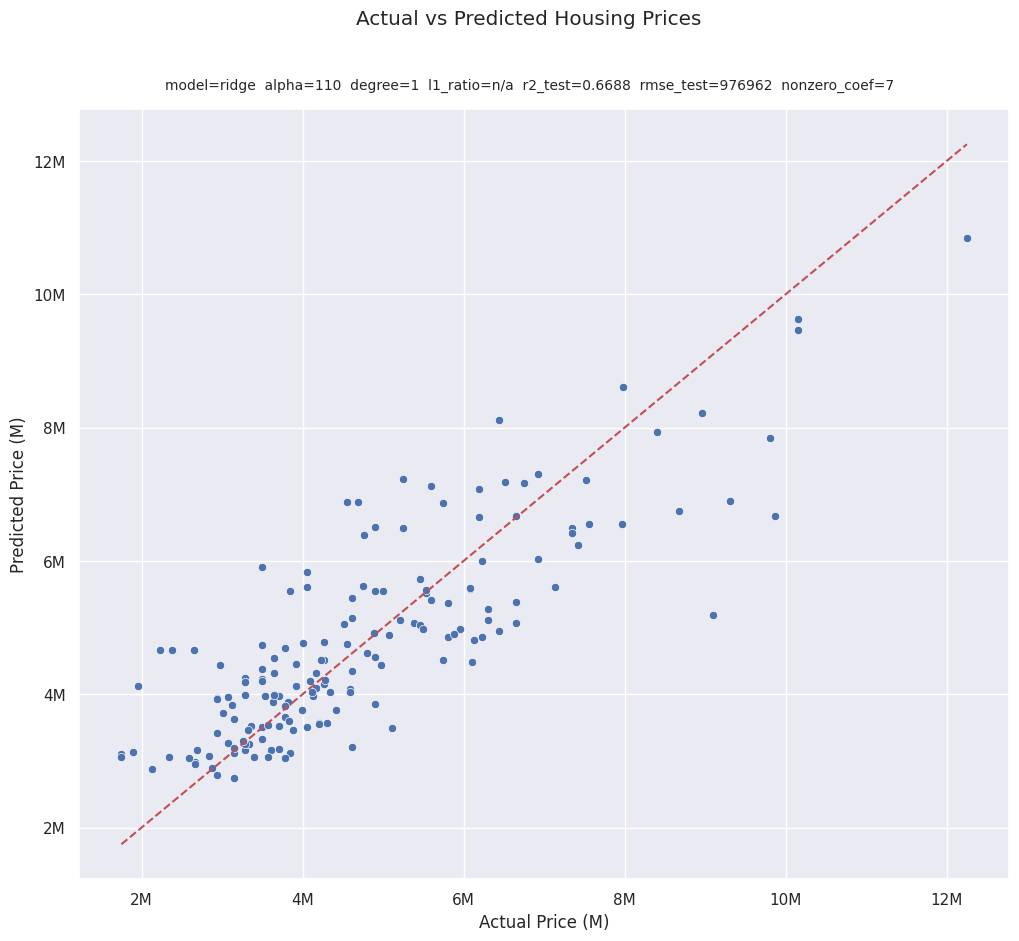

In [ ]:
plot_prediction(X, y, best_model, best_params)

We create a function to show the feature importance based on the model's coefficients. In the case of polynomial, beacuse of the big amount of those, we show only the most relevant ones.

In [ ]:
def plot_feature_importance(best_params):
  """
  Plots feature importance based on regression coefficients.
  best_params: output from 'grid_search_cv'.
  """
  coef = best_params["coef"]
  feature_names = best_params["feature_names"]
  degree = best_params["degree"]

  coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
  coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
  if degree > 1:
    top_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
  else:
    top_features = coef_df

  sns.barplot(x='Coefficient', y='Feature', data=top_features)
  plt.suptitle("Feature Importance (Linear Regression Coefficients)", fontsize=16)
  plt.figtext(0.5, 0.90, f"model={best_params['model_name']}  alpha={best_params['alpha']}  degree={degree}  l1_ratio={best_params['l1_ratio']}  r2_test={best_params['r2_test']:.4f}  rmse_test={best_params['rmse_test']:.0f}  nonzero_coef={best_params['nonzero_coef']}", ha="center", fontsize=10)
  plt.xlabel('Coefficient')
  plt.ylabel('Feature (most relevant shown)')
  plt.show()

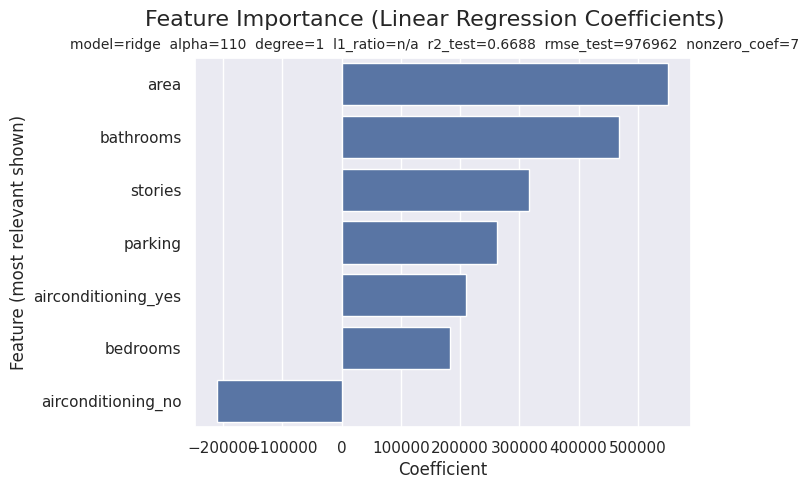

In [ ]:
plot_feature_importance(best_params)

# 2.b. Model #2

In this model we'll try using all the features available.

In [ ]:
X = df_ohe.drop("price", axis=1)
y = df_ohe["price"]

### Linear regression

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="lr", poly_degrees=[1,2,3])

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
3,lr,1,n/a,n/a,0.6700,1045729613766,1022609,0.6956,1444339643406,1201807,20
0,lr,1,n/a,n/a,0.6823,1157928019786,1076071,0.6611,976484771025,988172,20
6,lr,1,n/a,n/a,0.6871,1119628241956,1058125,0.6368,1120667259413,1058616,20
9,lr,1,n/a,n/a,0.6903,1085095663486,1041679,0.6354,1252872967962,1119318,20
12,lr,1,n/a,n/a,0.6902,1102862613216,1050173,0.6341,1179361744819,1085984,20


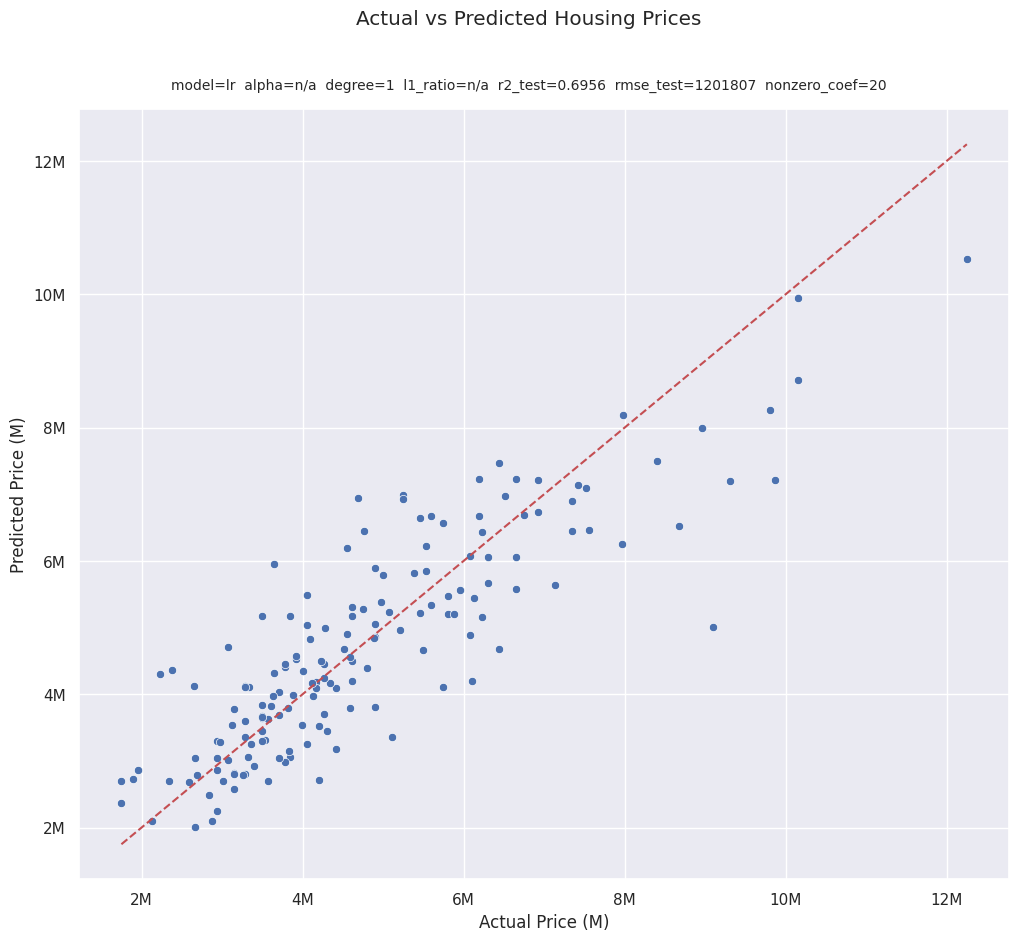

In [ ]:
plot_prediction(X, y, best_model, best_params)

### Ridge

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="ridge", alpha_values=[.1, 1, 5, 10, 20, 50, 100, 200], poly_degrees=[1,2,3])

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
38,ridge,2,100.0,n/a,0.7392,826411256626,909072,0.7207,1324977774432,1151077,221
39,ridge,2,200.0,n/a,0.7272,864500890887,929785,0.7196,1330080078897,1153291,221
37,ridge,2,50.0,n/a,0.7502,791752740441,889805,0.7175,1340200816670,1157670,221
36,ridge,2,20.0,n/a,0.7620,754280145941,868493,0.7065,1392213230819,1179921,221
26,ridge,1,5.0,n/a,0.6700,1045810907942,1022649,0.6956,1444240321314,1201766,20


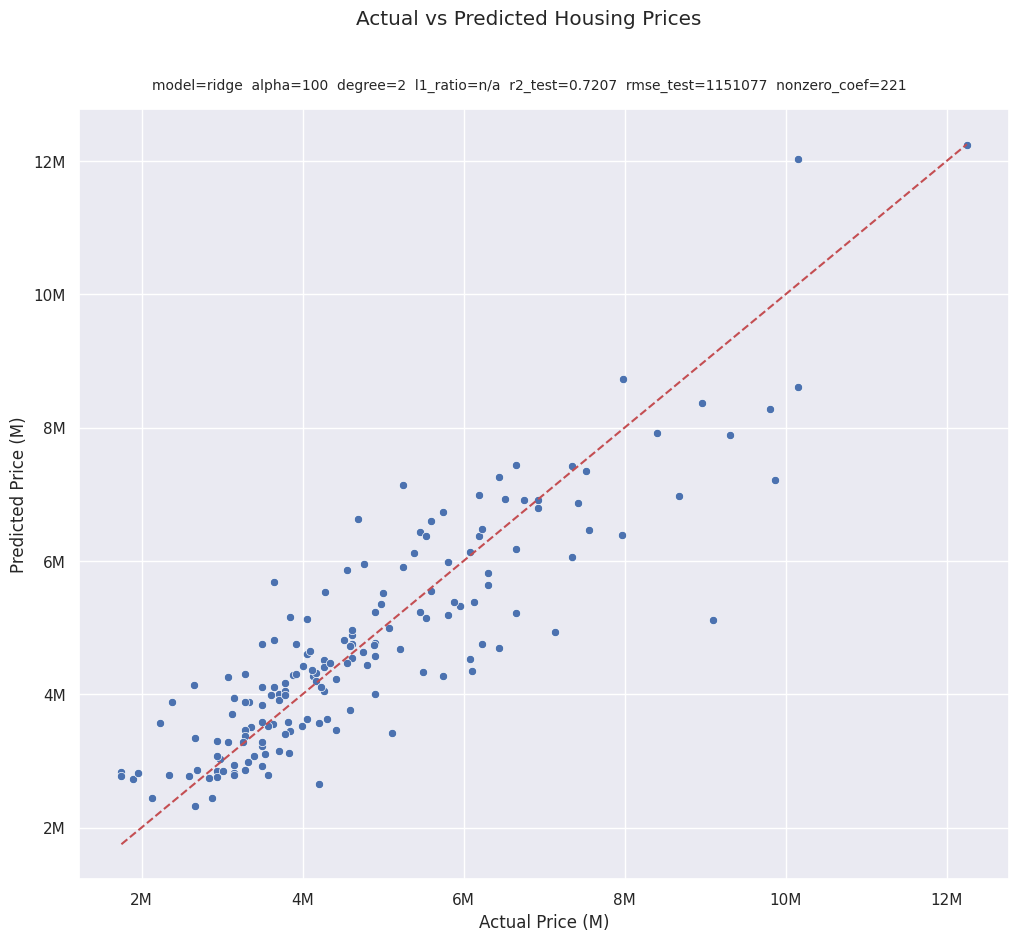

In [ ]:
plot_prediction(X, y, best_model, best_params)

### Lasso

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="lasso", alpha_values=[.1, 1, 5, 10], poly_degrees=[1,2,3])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e+13, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e+13, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e+13, tolerance: 1.589e

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
12,lasso,1,0.1,n/a,0.6700,1045729613766,1022609,0.6956,1444339728127,1201807,18
13,lasso,1,1.0,n/a,0.6700,1045729613774,1022609,0.6956,1444340565663,1201807,16
14,lasso,1,5.0,n/a,0.6700,1045729613950,1022609,0.6956,1444344303706,1201809,15
15,lasso,1,10.0,n/a,0.6700,1045729614508,1022609,0.6956,1444349093591,1201811,18
3,lasso,1,10.0,n/a,0.6823,1157928020453,1076071,0.6611,976471215755,988166,20


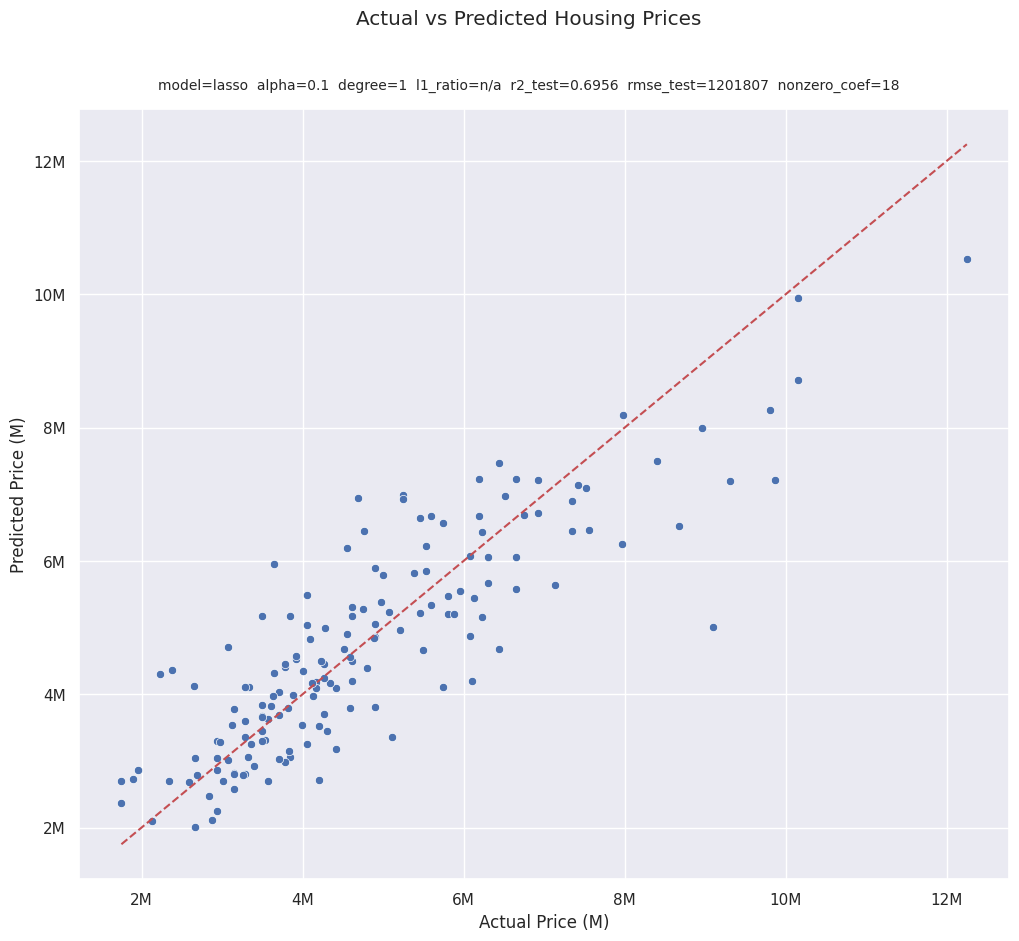

In [ ]:
plot_prediction(X, y, best_model, best_params)

### ElasticNet

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="elasticnet", alpha_values=[.1, 1, 5, 10, 20, 50, 100, 200], poly_degrees=[1,2,3])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e+14, tolerance: 1.589e

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
33,elasticnet,2,1.0,0.5,0.7257,869446094796,932441,0.7192,1332067526646,1154152,221
43,elasticnet,3,10.0,0.5,0.7399,824231810062,907872,0.7133,1360146394896,1166253,1562
42,elasticnet,3,5.0,0.5,0.7587,764648812832,874442,0.7129,1362092838335,1167087,1561
32,elasticnet,2,0.1,0.5,0.7611,757179535110,870161,0.7078,1386136687493,1177343,221
44,elasticnet,3,20.0,0.5,0.7197,888388275413,942544,0.7053,1397918462340,1182336,1562


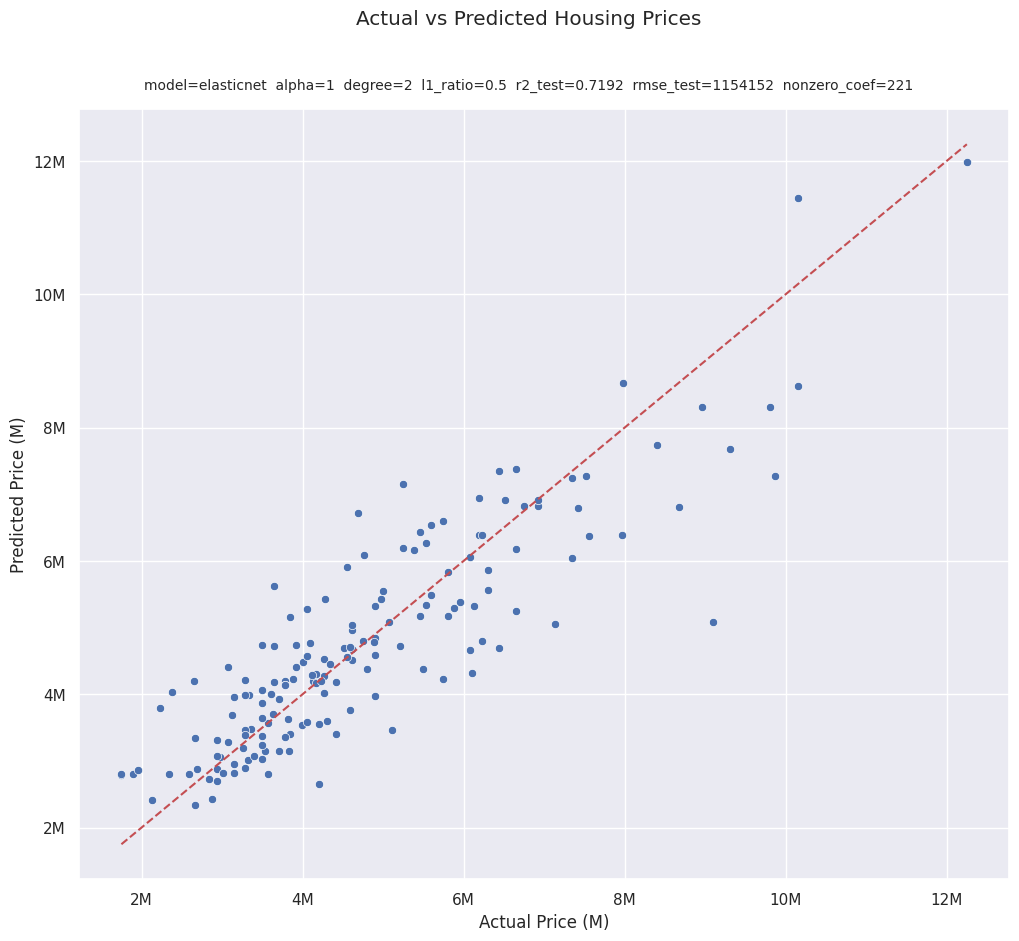

In [ ]:
plot_prediction(X, y, best_model, best_params)

## Now we'll do fine-tuning on the best models (Ridge and ElasticNet)

i) Ridge fine-tuning

In [ ]:
results, best_params, best_model = grid_search_cv(X, y, model_name="ridge", alpha_values=[80, 90, 100, 110], poly_degrees=[2])

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
7,ridge,2,110,n/a,0.7376,831470437757,911850,0.7208,1324507533176,1150873,221
6,ridge,2,100,n/a,0.7392,826411256626,909072,0.7207,1324977774432,1151077,221
5,ridge,2,90,n/a,0.7410,820891384926,906031,0.7205,1325946032357,1151497,221
4,ridge,2,80,n/a,0.7429,814816854164,902672,0.7202,1327592357212,1152212,221
19,ridge,2,110,n/a,0.7624,845605613742,919568,0.6644,1081617030688,1040008,221


In [ ]:
results, best_params, _ = grid_search_cv(X, y, model_name="ridge", alpha_values=[120, 130, 140, 150], poly_degrees=[2])

In [ ]:
results.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test,nonzero_coef
4,ridge,2,120,n/a,0.7362,836141141414,914408,0.7208,1324410950398,1150831,221
5,ridge,2,130,n/a,0.7348,840480032736,916777,0.7208,1324599584484,1150913,221
6,ridge,2,140,n/a,0.7335,844532380198,918984,0.7207,1325008998646,1151090,221
7,ridge,2,150,n/a,0.7323,848334912723,921051,0.7206,1325591285517,1151343,221
19,ridge,2,150,n/a,0.7572,864111032882,929576,0.6658,1077190773334,1037878,221


Ridge, degree=2, alpha=120, r2=.7208, rmse=1150831, seems to be a good spot.

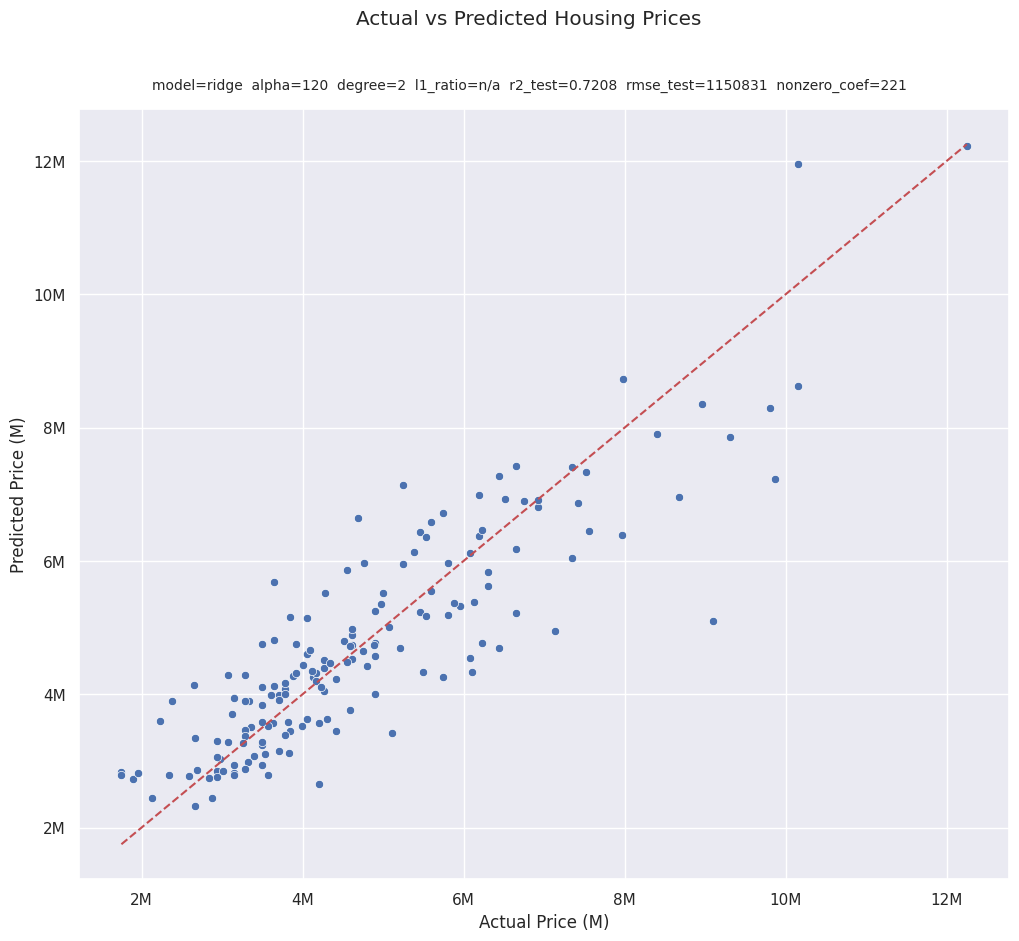

In [ ]:
plot_prediction(X, y, best_model, best_params)

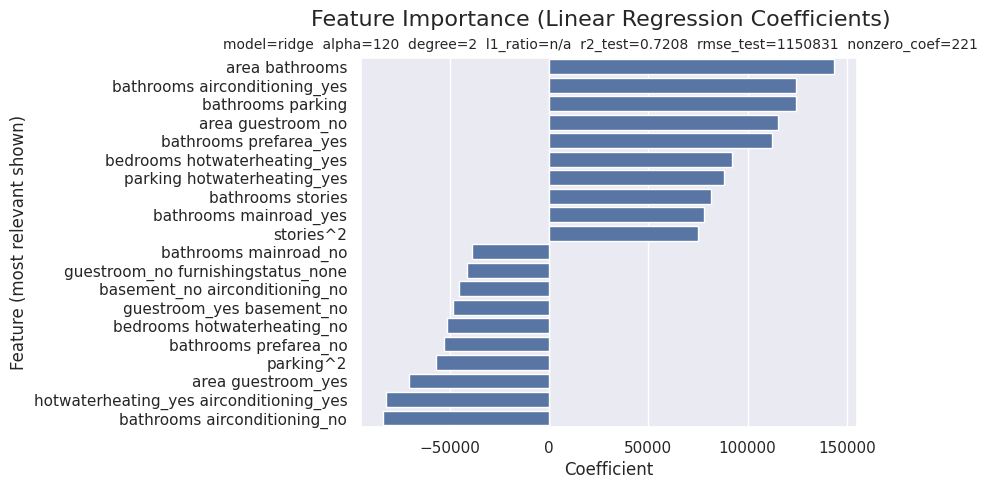

In [ ]:
plot_feature_importance(best_params)

### ii) ElasticNet fine-tuning

We iterate through L1 ratio values to find an optimum:

In [ ]:
l1_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = pd.DataFrame(columns=best_params.index.tolist())

for l1_ratio in l1_values:
  _, best_params, _ = grid_search_cv(X, y, model_name="elasticnet", alpha_values=[.5, 1, 1.5, 2, 5], poly_degrees=[2], l1_ratio=l1_ratio)
  best_params_df = pd.DataFrame([best_params.to_dict()])
  results = pd.concat([results, best_params_df], ignore_index=True)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.583e+12, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.710e+11, tolerance: 1.382e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e+12, tolerance: 1.560e

In [ ]:
ordered = results.sort_values(by=['r2_test', 'rmse_test'], ascending=[False, True])

In [ ]:
ordered.head()

,model_name,degree,alpha,l1_ratio,r2_train,mse_train,rmse_train,r2_test,rmse_test,nonzero_coef,feature_names,coef
4,elasticnet,2,0.5,0.5,0.737802,8.309838e+11,911583.108873,0.720813,1.150884e+06,221,"[1, area, bedrooms, bathrooms, stories, parkin...","[0.0, 74782.75205895455, 26510.071512986156, 6..."
3,elasticnet,2,0.5,0.4,0.734700,8.408150e+11,916959.670099,0.720794,1.150924e+06,221,"[1, area, bedrooms, bathrooms, stories, parkin...","[0.0, 72935.35255950951, 23788.1266986169, 625..."
6,elasticnet,2,1.0,0.7,0.734700,8.408168e+11,916960.647644,0.720794,1.150925e+06,221,"[1, area, bedrooms, bathrooms, stories, parkin...","[0.0, 72935.332854996, 23787.12440106295, 6255..."
7,elasticnet,2,1.5,0.8,0.734699,8.408186e+11,916961.625209,0.720793,1.150925e+06,221,"[1, area, bedrooms, bathrooms, stories, parkin...","[0.0, 72935.31315063633, 23786.12210340031, 62..."
2,elasticnet,2,0.5,0.3,0.732027,8.492870e+11,921567.699335,0.720554,1.151420e+06,221,"[1, area, bedrooms, bathrooms, stories, parkin...","[0.0, 71493.88819706682, 21950.01733807316, 62..."


The optimal L1 ratio is still 0.5, but with an alpha=0.5 the RMSE is even lower.

We can list the coefficients:

In [ ]:
def list_coefficients(coef, columns):

  print("\nFeature Importance (Linear Regression Coefficients):")
  coefficients = pd.DataFrame({
      'Feature': columns,
      'Coefficient': coef
  }).sort_values(by='Coefficient', ascending=False)

  print(coefficients)

In [ ]:
feature_names = df_ohe.drop("price", axis=1).columns

list_coefficients(ordered.iloc[0]["coef"], ordered.iloc[0]["feature_names"])


Feature Importance (Linear Regression Coefficients):
                                     Feature    Coefficient
23                            area bathrooms  147246.975348
62                         bathrooms parking  130022.840276
72             bathrooms airconditioning_yes  129617.528747
28                         area guestroom_no  121393.593250
74                    bathrooms prefarea_yes  117354.066613
..                                       ...            ...
73                     bathrooms prefarea_no  -57237.932480
95                                 parking^2  -62207.335978
29                        area guestroom_yes  -76621.525729
197  hotwaterheating_yes airconditioning_yes  -84113.154007
71              bathrooms airconditioning_no  -88984.941392

[231 rows x 2 columns]


Obtain the best ElasticNet model to plot

In [ ]:
_, best_params, eln_model = grid_search_cv(X, y, model_name="elasticnet", alpha_values=[.5], poly_degrees=[2], l1_ratio=.5)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e+14, tolerance: 1.589e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e+14, tolerance: 1.382e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e+14, tolerance: 1.560e

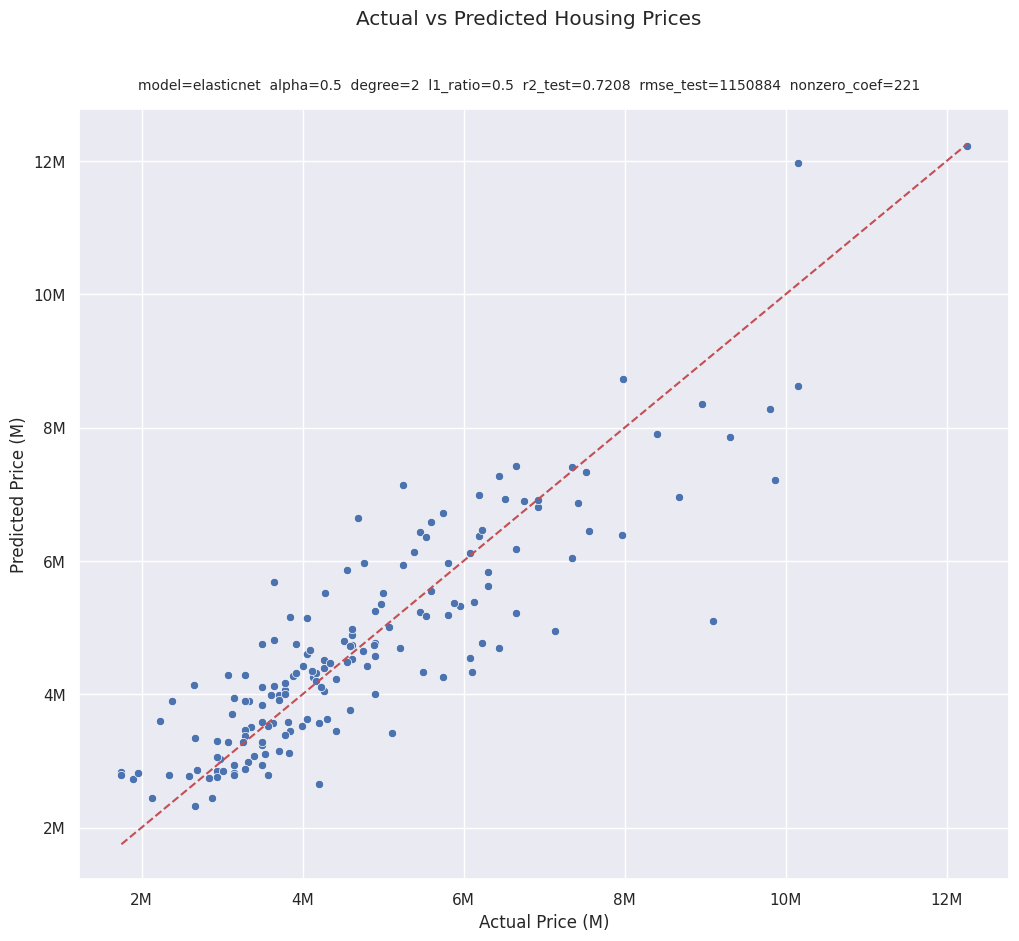

In [ ]:
plot_prediction(X, y, eln_model, best_params)

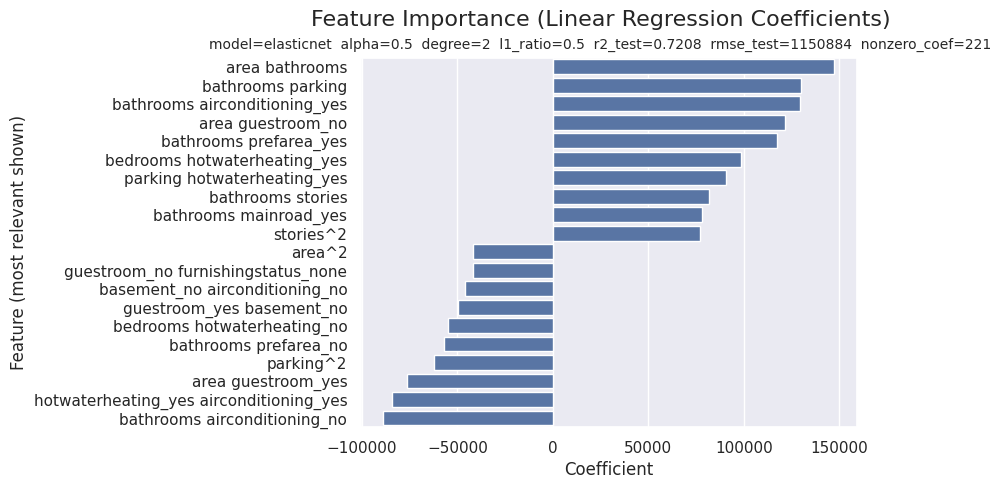

In [ ]:
plot_feature_importance(best_params)

We can see that the obtained Ridge model is slightly better than ElasticNet
RMSE: 1150831 vs 1150884, respectively.

# 3. Conclusions

Comparing the two best models achieved by using all features available, the combination of features that have more weight for the model are pretty much the same in both models (Ridge and ElasticNet).  

The main deference is on the pair bathrooms-airconditioning_yes that on the Ridge model appears $2^{nd}$, and bathrooms-parking $3^{rd}$, while in the ElasticNet they swap positions. But also we can notice in the chart that their importance are almost the same.

Because of a lower RMSE we choose as best model the following:  

Ridge:   
polynomial degree = 2  
$\alpha$ = 20  
$R^2$ = 0.7208 (good)  
RMSE = 1.150.831  
Non-zero coefficients: 221  

Feature importance analysis, in order:

i) Area/Bathrooms: total $m^2$ and number of bathrooms, those features together have the highest, positive impact on the price. That makes sense.  

ii) Bathrooms: continues to appear on the top features, together with
Air Conditioning (Yes), Parking, Preferred Area (Yes), Stories, standing as the second important feature that influence the price.

iii) Air Conditioning (Yes)/Bathrooms and Parking/Bathrooms: those share almost the same weight

iv) Area/Guestroom (No): this combination suggests that Area and Guestroom (No) have a posiitive impact on price.  

v) Regarding the negative coefficients, having bathrooms but no air conditioning, and having hot water heating and air conditioning, show a negative impact on price.


Note: When plotting the predictions we still see a straight line despite being a quadratic equation. That can happen depending on how close is to a linear equation.  






Pablo Di Marco